In [1]:
import time
import sys
import os
from PIL import Image
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras import layers, regularizers
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import warnings
warnings.simplefilter("ignore")

In [2]:
train_img= r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Training"
labels = os.listdir(train_img)
print("No. of labels in the Training set: {}".format(len(labels)))
print("-----------------")
os.chdir(train_img)
for label in labels:
    print("{}, {} files".format(label, len(os.listdir(train_img+ '//' +label))))

No. of labels in the Training set: 2
-----------------
colon_aca, 3493 files
colon_n, 3487 files


In [3]:
test_img = r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Testing"
labels = os.listdir(test_img)
print("No. of labels in the Testing set: {}".format(len(labels)))
print("-----------------")
os.chdir(test_img)
for label in labels:
    print("{}, {} files".format(label, len(os.listdir(test_img+ '//' +label))))

No. of labels in the Testing set: 2
-----------------
colon_aca, 1003 files
colon_n, 1003 files


Next, we will plot 10 images aca tumor training images

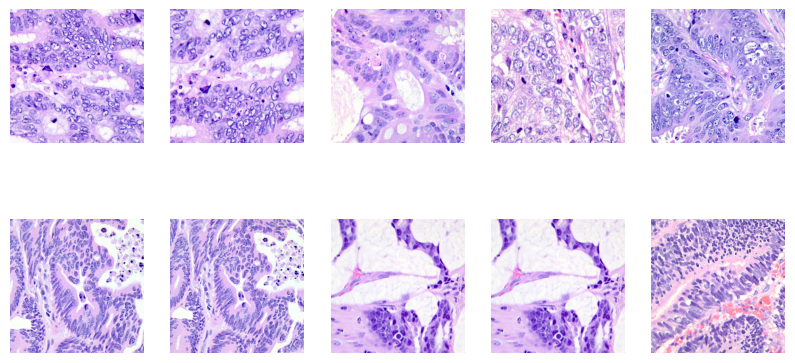

In [4]:
colon_aca = r"C:\Users\Asus\Desktop\PG Project\Nandhini\colon_image_set\colon_image_sets\Training\colon_aca"
sub_class = os.listdir(colon_aca)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:10])):
    plt.subplot(2,5,e+1)
    img = plt.imread(os.path.join(colon_aca,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

Since this dataset already contains augmented images, so further data augmentation will not be required.  
We will use the ImageDataGenerator class from Keras to split the data into training and validation sets.

In [5]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)
                                


train_generator = img_datagen.flow_from_directory(train_img,
                                                  class_mode='binary',
                                                 shuffle=True,
                                                 batch_size=32,
                                                 subset='training',
                                                 target_size=(100,100))
                                                 
valid_generator = img_datagen.flow_from_directory(test_img,
                                                 shuffle=True,
                                                  class_mode='binary',
                                                  batch_size=16,
                                                  subset='validation',
                                                 target_size=(100,100))

# Create a lablel_map dictionary that we will use for predicting on unseen data
label_map = (train_generator.class_indices)
print('Label mappings:\n')
label_map

Found 5585 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Label mappings:



{'colon_aca': 0, 'colon_n': 1}

##  CNN model 
 

In [6]:
from tensorflow.keras import regularizers

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(100,100,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.4))


model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [7]:
callbacks_list = [EarlyStopping( monitor='accuracy', patience=2 ),
                  ModelCheckpoint( filepath='/content/drive/MyDrive/train results/models/keras_colon_cancer_classification.h5',
                                  monitor='val_accuracy', save_best_only=True, ) ]


Next, we compile the model using the adam optimizer and the categoical_crossentropy loss function since this is a multi-class classification problem.

In [8]:
model.compile(optimizer=RMSprop(),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])
#optimizer='adam'
              


In [9]:
history = model.fit(train_generator, validation_data=valid_generator,
                   steps_per_epoch=train_generator.n//train_generator.batch_size,
                   validation_steps=valid_generator.n//valid_generator.batch_size,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)],
                    epochs=14)

Epoch 1/14
174/174 [==============================] - 105s 595ms/step - loss: 0.7239 - accuracy: 0.5186 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 2/14
174/174 [==============================] - 103s 594ms/step - loss: 0.6932 - accuracy: 0.5046 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 3/14
174/174 [==============================] - 105s 602ms/step - loss: 0.6921 - accuracy: 0.5384 - val_loss: 0.7217 - val_accuracy: 0.5000
Epoch 4/14
174/174 [==============================] - 105s 601ms/step - loss: 0.6585 - accuracy: 0.6197 - val_loss: 0.6895 - val_accuracy: 0.5125
Epoch 5/14
174/174 [==============================] - 105s 601ms/step - loss: 0.6202 - accuracy: 0.6456 - val_loss: 0.5351 - val_accuracy: 0.7475
Epoch 6/14
174/174 [==============================] - 104s 596ms/step - loss: 0.5702 - accuracy: 0.7079 - val_loss: 0.4887 - val_accuracy: 0.7725
Epoch 7/14
174/174 [==============================] - 107s 613ms/step - loss: 0.5048 - accuracy: 0.7767 - val_loss: 0.4674 -

### Plotting model training and validation curves.


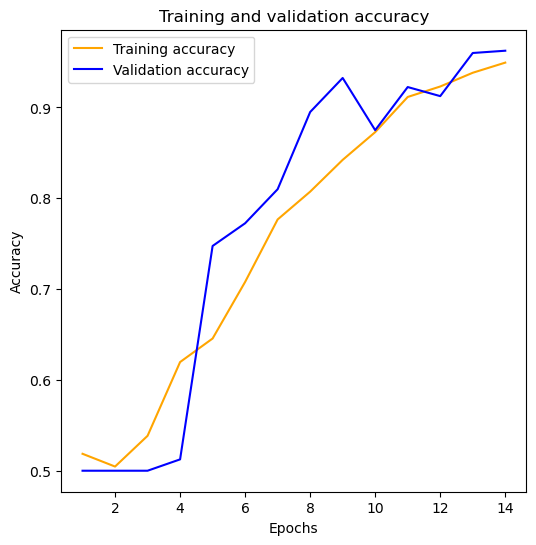

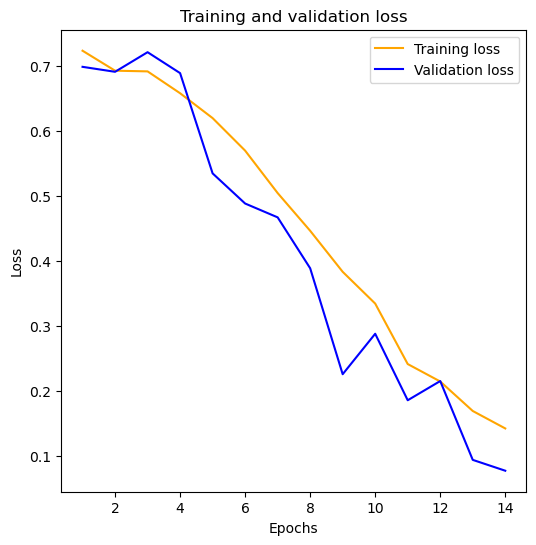

In [10]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_accuracy) + 1)
plt.figure(figsize=(6,6))
plt.plot(epochs, training_accuracy, 'orange', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(6,6))

plt.plot(epochs, training_loss, 'orange', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [13]:
    temph = history.history
    temp_loss = temph['loss']
    temp_acc = temph['accuracy']
    temp_vloss = temph['val_accuracy']
    temp_vacc = temph['val_accuracy']

    max_valacc = max(temp_vacc)
    max_index = temp_vacc.index(max_valacc)
    max_index
    # Print the result from the last epoch
  
    print('Train accuracy: %s'%history.history['accuracy'][-1])
    print('Validation accuracy: %s'%history.history['val_accuracy'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1) 

Train accuracy: 0.9493967294692993
Validation accuracy: 0.9624999761581421


25/25 [==============================] - 6s 244ms/step


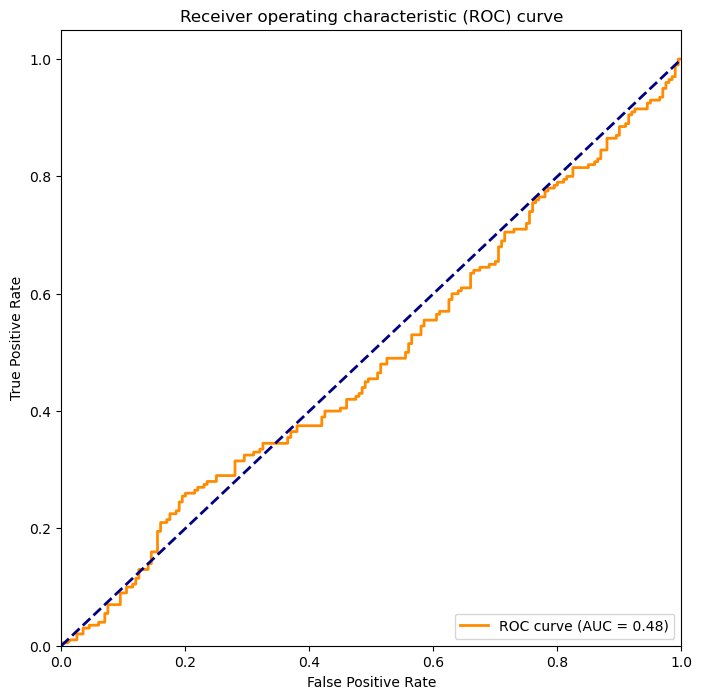

In [12]:
from sklearn.metrics import roc_curve, auc

# make predictions on the validation set
y_pred = model.predict(valid_generator)

# get the true labels for the validation set
y_true = valid_generator.classes

# calculate the false positive rate, true positive rate, and threshold for various probability thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# plot the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()


In [54]:
y_pred = model.predict(valid_generator)
print(y_pred.shape)



25/25 [==============================] - 4s 157ms/step
(400, 1)


### this code is for CNN 

In [14]:
# Define evaluation metrics
from sklearn.metrics import classification_report

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(valid_generator)

# Make predictions on the validation set
y_pred = model.predict(valid_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = valid_generator.classes

# Print evaluation metrics
print('Loss: {:.4f}'.format(loss))
print('Accuracy: {:.4f}'.format(accuracy))
print(classification_report(y_true, y_pred))


25/25 [==============================] - 6s 237ms/step
Loss: 0.0774
Accuracy: 0.9625
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       200
           1       0.00      0.00      0.00       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



### RESNET50

In [27]:
import fastai
import fastbook
from fastai.metrics import RocAuc, Precision, Recall, F1Score

In [28]:
from fastai.vision.all import *
path = train_img

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path,bs=64)
#dls.normalize(imagenet_stats)

In [32]:
learn = cnn_learner(dls, models.resnet50, metrics=[accuracy, Precision(), Recall(), F1Score()])

In [33]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.054406,0.004354,0.997135,1.000000,0.994253,0.997118,1:37:24


In [34]:
interp_vgg = ClassificationInterpretation.from_learner(learn)

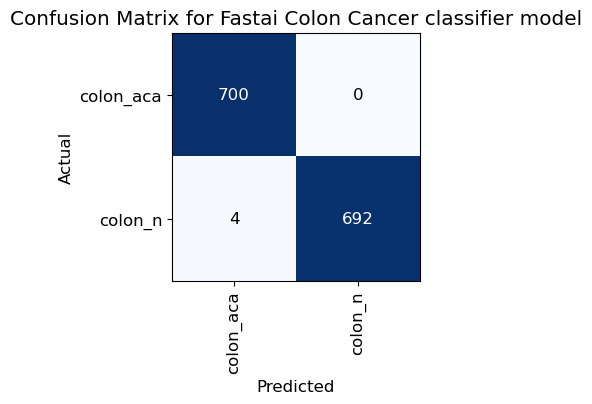

In [35]:
interp_vgg.plot_confusion_matrix(figsize=(4,4),
                                 title='Confusion Matrix for Fastai Colon Cancer classifier model')

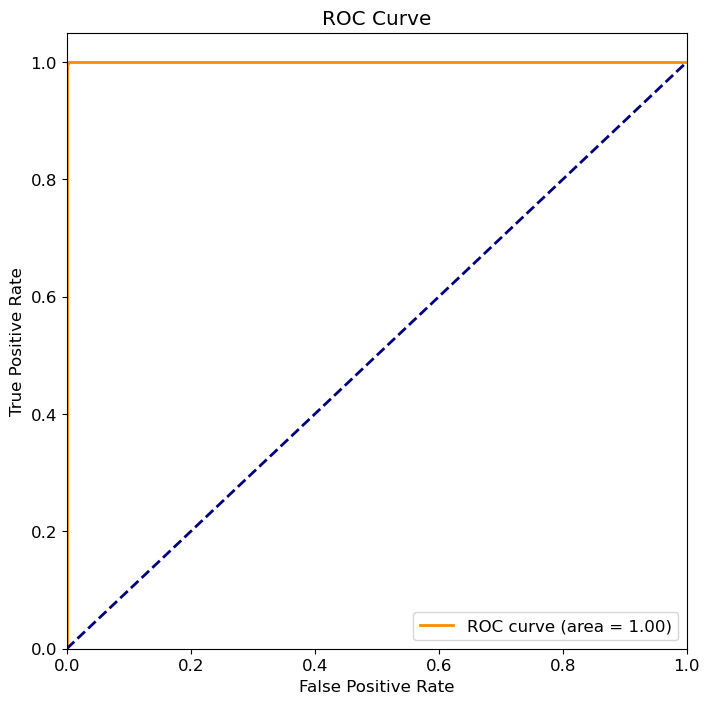

In [48]:
from sklearn.metrics import roc_curve, auc

probs, targets = learn.get_preds()

fpr, tpr, thresholds = roc_curve(targets, probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


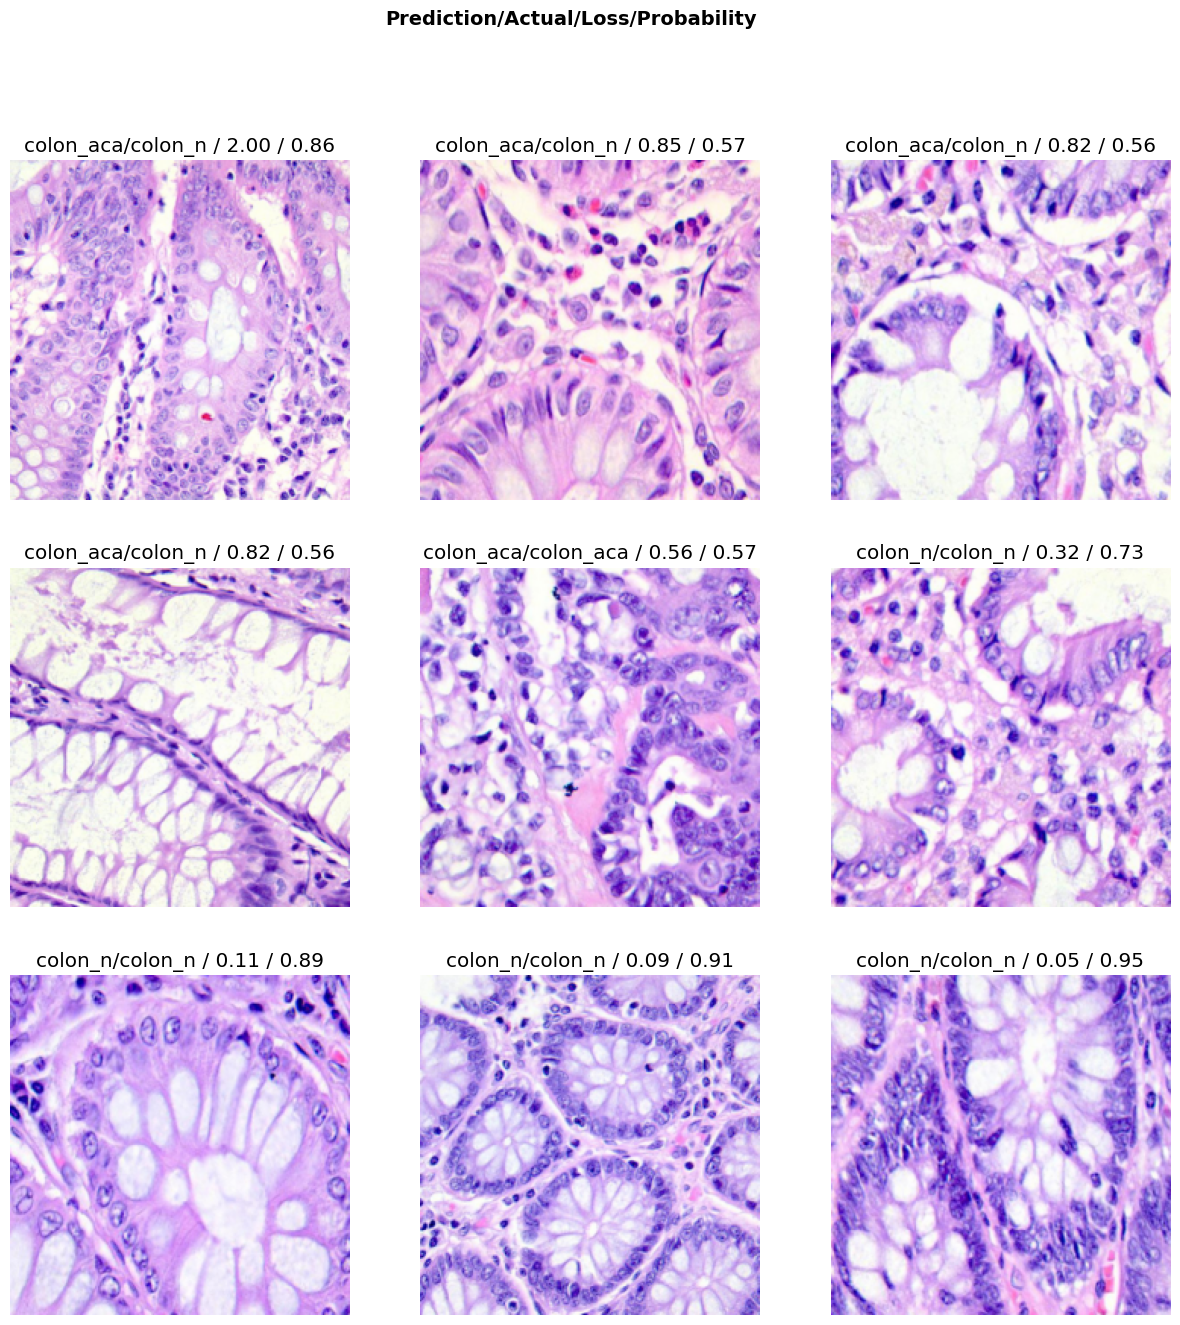

In [49]:
interp_vgg.plot_top_losses(9, figsize=(15,15))

In [46]:
interp_vgg.print_classification_report()

              precision    recall  f1-score   support

   colon_aca       0.99      1.00      1.00       700
     colon_n       1.00      0.99      1.00       696

    accuracy                           1.00      1396
   macro avg       1.00      1.00      1.00      1396
weighted avg       1.00      1.00      1.00      1396

